In [1]:
# Importing all the needed modules.
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
import keras
from keras.layers import Embedding,Dense, Dropout, Activation, Flatten, Conv1D,Conv2D,MaxPooling1D,Concatenate, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.engine.input_layer import Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.555)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


# Text Classification:

## Data
<pre>
1. we have total of 20 types of documents(Text files) and total 18828 documents(text files).
2. You can download data from this <a href='https://drive.google.com/open?id=1rxD15nyeIPIAZ-J2VYPrDRZI66-TBWvM'>link</a>, in that you will get documents.rar folder. <br>If you unzip that, you will get total of 18828 documnets. document name is defined as'ClassLabel_DocumentNumberInThatLabel'. 
so from document name, you can extract the label for that document.
4. Now our problem is to classify all the documents into any one of the class. 
</pre>

### Preprocessing:
<pre>
useful links: <a href='http://www.pyregex.com/'>http://www.pyregex.com/</a>

<font color='blue'><b>1.</b></font> Find all emails in the document and then get the text after the "@". and then split those texts by '.' 
after that remove the words whose length is less than or equal to 2 and also remove'com' word and then combine those words by space. 
In one doc, if we have 2 or more mails, get all.
<b>Eg:[test@dm1.d.com, test2@dm2.dm3.com]-->[dm1.d.com, dm3.dm4.com]-->[dm1,d,com,dm2,dm3,com]-->[dm1,dm2,dm3]-->"dm1 dm2 dm3" </b> 
append all those into one list/array. ( This will give length of 18828 sentences i.e one list for each of the document). 
Some sample output was shown below. 

> In the above sample document there are emails [jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu]

preprocessing:
[jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu] ==> [nyx cs du edu mimsy umd edu cs umd edu] ==> 
[nyx edu mimsy umd edu umd edu]

<font color='blue'><b>2.</b></font> Replace all the emails by space in the original text. 
</pre>

# Text pre-processing

In [2]:
import glob
import nltk
import re
from bs4 import BeautifulSoup

files = glob.glob("documents/*")

In [3]:
len(files)

18828

In [4]:
final = []; cread = 0; label = []; mlen = 0; idx = 0; subj = []; orgtxt = []
for enm,doc in enumerate(files):
    try:
        f = open(doc,'r', encoding='utf8')
        content = f.read()
    
    
        soup = BeautifulSoup(content)
        text = soup.get_text()
        p1 = re.findall(r'[a-zA-Z0-9-]+[a-zA-Z0-9-\.]*@([a-zA-Z0-9-]+[a-zA-Z0-9-\.]*)', text)
        otxt = re.sub(r'[a-zA-Z0-9-]+[a-zA-Z0-9-\.]*@([a-zA-Z0-9-]+[a-zA-Z0-9-\.]*)',"",text)
        em = ""
        for each in p1:
            for word in each.split('.'):
                if len(word) > 2 and word != 'com':
                    em += word
                    em += " "

        if len(em) > 2:
            label.append(doc.split('/')[1].split('_')[0])
            final.append(em[:-1].lower())
            if len(em[:-1]) > mlen:
                mlen = len(em)
                idx = enm

            txt = re.findall(r'Subject\:[ Re\:]*([A-Za-z0-9\:\(\)\! ]*)', text)
            otxt = re.sub(r'Subject\:[ Re\:]*([A-Za-z0-9\:\(\)\! ]*)',"",otxt)
            sub = ""
            for each in txt:
                sub += re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "",each)
            subj.append(sub)
            orgtxt.append(otxt)
    except:
        continue

print(final[0],len(final),len(label),len(subj))

hpuerca atl 18380 18380 18380


In [5]:
body = []
for tmp in orgtxt:
    tmp = re.sub(r'From\:[ Re\:]*([A-Za-z0-9\:\(\)\!\. ]*)',"", tmp)
    tmp = re.sub(r'Write to\:[ Re\:]*([A-Za-z0-9\:\(\)\!\. ]*)',"", tmp)
    tmp = re.sub(r'\([A-Za-z0-9\:\!\.\-\,\;\'\`\n\t\?\/\>\<\$ ]*\)',"", tmp)
    tmp = re.sub(r'\<[A-Za-z0-9\:\!\.\-\,\;\'\`\n\t\?\/ ]*\>',"", tmp)
    tmp = re.sub(r'[\n\t\-\\\/\|]'," ",tmp)
    text = re.sub(r'[A-Za-z0-9]*\:',"",tmp)

    parse_tree = nltk.ne_chunk(nltk.tag.pos_tag(text.split()), binary=True) 
    ctxt = ""
    chunk = list(parse_tree)

    for each in chunk:
        if isinstance(each, nltk.tree.Tree):
            ctxt += '_'.join(k[0] for k in each)
            ctxt += ' '
        else:
            ctxt += each[0]+' '

    text = ctxt.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[0-9]", "", text)
    text = re.sub(r" [a-zA-Z]\_", " ", text)
    text = re.sub(r" [a-zA-Z][a-zA-Z]\_", " ", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,$%^&*'/+\[\]]+", "", text)
    text = re.sub(r"\b[a-zA-Z]{1,2}\b", "", text)
    text = re.sub(r"\b[a-zA-Z]{15,}\b", "", text)
    text = re.sub(r' _'," ", text)
    text = re.sub(r'_ '," ", text)
    text = re.sub(r'__+'," ", text)
    text = re.sub(r" +", " ", text)
    body.append(text)

len(body)

18380

<pre>
<font color='blue'><b>3.</b></font> Get subject of the text i.e. get the total lines where "Subject:" occur and remove 
the word which are before the ":" remove the newlines, tabs, punctuations, any special chars.
<b>Eg: if we have sentance like "Subject: Re: Gospel Dating @ \r\r\n" --> You have to get "Gospel Dating"</b> 
Save all this data into another list/array. 

<font color='blue'><b>4.</b></font> After you store it in the list, Replace those sentances in original text by space.

<font color='blue'><b>5.</b></font> Delete all the sentances where sentence starts with <b>"Write to:"</b> or <b>"From:"</b>.
> In the above sample document check the 2nd line, we should remove that

<font color='blue'><b>6.</b></font> Delete all the tags like "< anyword >"
> In the above sample document check the 4nd line, we should remove that "< 65882@mimsy.umd.edu >"


<font color='blue'><b>7.</b></font> Delete all the data which are present in the brackets. 
In many text data, we observed that, they maintained the explanation of sentence 
or translation of sentence to another language in brackets so remove all those.
<b>Eg: "AAIC-The course that gets you HIRED(AAIC - Der Kurs, der Sie anstellt)" --> "AAIC-The course that gets you HIRED"</b>

> In the above sample document check the 4nd line, we should remove that "(Charley Wingate)"


<font color='blue'><b>8.</b></font> Remove all the newlines('\n'), tabs('\t'), "-", "\".

<font color='blue'><b>9.</b></font> Remove all the words which ends with <b>":"</b>.
<b>Eg: "Anyword:"</b>
> In the above sample document check the 4nd line, we should remove that "writes:"


<font color='blue'><b>10.</b></font> Decontractions, replace words like below to full words. 
please check the donors choose preprocessing for this 
<b>Eg: can't -> can not, 's -> is, i've -> i have, i'm -> i am, you're -> you are, i'll --> i will </b>

<b> There is no order to do point 6 to 10. but you have to get final output correctly</b>

<font color='blue'><b>11.</b></font> Do chunking on the text you have after above preprocessing. 
Text chunking, also referred to as shallow parsing, is a task that 
follows Part-Of-Speech Tagging and that adds more structure to the sentence.
So it combines the some phrases, named entities into single word.
So after that combine all those phrases/named entities by separating <b>"_"</b>. 
And remove the phrases/named entities if that is a "Person". 
You can use <b>nltk.ne_chunk</b> to get these. 
Below we have given one example. please go through it. 

useful links: 
<a href='https://www.nltk.org/book/ch07.html'>https://www.nltk.org/book/ch07.html</a>
<a href='https://stackoverflow.com/a/31837224/4084039'>https://stackoverflow.com/a/31837224/4084039</a>
<a href='http://www.nltk.org/howto/tree.html'>http://www.nltk.org/howto/tree.html</a>
<a href='https://stackoverflow.com/a/44294377/4084039'>https://stackoverflow.com/a/44294377/4084039</a>
</pre>

In [0]:
#i am living in the New York
print("i am living in the New York -->", list(chunks))
print(" ")
print("-"*50)
print(" ")
#My name is Srikanth Varma
print("My name is Srikanth Varma -->", list(chunks1))

i am living in the New York --> [('i', 'NN'), ('am', 'VBP'), ('living', 'VBG'), ('in', 'IN'), ('the', 'DT'), Tree('GPE', [('New', 'NNP'), ('York', 'NNP')])]
 
--------------------------------------------------
 
My name is Srikanth Varma --> [('My', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), Tree('PERSON', [('Srikanth', 'NNP'), ('Varma', 'NNP')])]


<pre>We did chunking for above two lines and then We got one list where each word is mapped to a 
POS(parts of speech) and also if you see "New York" and "Srikanth Varma", 
they got combined and represented as a tree and "New York" was referred as "GPE" and "Srikanth Varma" was referred as "PERSON". 
so now you have to Combine the "New York" with <b>"_"</b> i.e "New_York"
and remove the "Srikanth Varma" from the above sentence because it is a person.</pre>

<pre>
<font color='blue'><b>13.</b></font> Replace all the digits with space i.e delete all the digits. 
> In the above sample document, the 6th line have digit 100, so we have to remove that.

<font color='blue'><b>14.</b></font> After doing above points, we observed there might be few word's like
 <b> "_word_" (i.e starting and ending with the _), "_word" (i.e starting with the _),
  "word_" (i.e ending with the _)</b> remove the <b>_</b> from these type of words. 

<font color='blue'><b>15.</b></font>  We also observed some words like <b> "OneLetter_word"- eg: d_berlin, 
"TwoLetters_word" - eg: dr_berlin </b>, in these words we remove the "OneLetter_" (d_berlin ==> berlin) and 
"TwoLetters_" (de_berlin ==> berlin). i.e remove the words 
which are length less than or equal to 2 after spliiting those words by "_". 

<font color='blue'><b>16.</b></font> Convert all the words into lower case and lowe case 
and remove the words which are greater than or equal to 15 or less than or equal to 2.

<font color='blue'><b>17.</b></font> replace all the words except "A-Za-z_" with space. 

<font color='blue'><b>18.</b></font> Now You got Preprocessed Text, email, subject. create a dataframe with those. 
Below are the columns of the df. 
</pre>

In [6]:
len(final),len(subj),len(body),len(label)

(18380, 18380, 18380, 18380)

In [7]:
data = []
for a,b,c in zip(final,subj,body):
    data.append(a+" "+b.lower()+" "+c)
len(data)

18380

In [8]:
data[1]

'wmich edu lab wmich edu prk referral in canada could some please refer someone who can perform prk canada have looked the yellow pages with little success and someone has had good experience that would especially helpful you could please let know thanks kurt hozak '

In [9]:
import pandas as pd
df = pd.DataFrame(data, columns = ['text']) 
df['label'] = label

df.head()

,text,label
0,hpuerca atl super mega automobile sightings ex...,rec.autos
1,wmich edu lab wmich edu prk referral in canada...,sci.med
2,netcom cats ucsc edu netcom help duo 230 probl...,comp.sys.mac.hardware
3,ulkyvx louisville edu camelot bradley edu and ...,rec.sport.baseball
4,gauss med harvard edu sol ctr columbia edu sta...,rec.sport.hockey


### Training The models to Classify: 

<pre>
1. Combine "preprocessed_text", "preprocessed_subject", "preprocessed_emails" into one column. use that column to model. 

2. Now Split the data into Train and test. use 25% for test also do a stratify split. 

3. Analyze your text data and pad the sequnce if required. 
Sequnce length is not restricted, you can use anything of your choice. 
you need to give the reasoning

4. Do Tokenizer i.e convert text into numbers. please be careful while doing it. 
if you are using tf.keras "Tokenizer" API, it removes the <b>"_"</b>, but we need that.

5. code the model's ( Model-1, Model-2 ) as discussed below 
and try to optimize that models.  

6. For every model use predefined Glove vectors. 
<b>Don't train any word vectors while Training the model.</b>

7. Use "categorical_crossentropy" as Loss. 

8. Use <b>Accuracy and Micro Avgeraged F1 score</b> as your as Key metrics to evaluate your model. 

9.  Use Tensorboard to plot the loss and Metrics based on the epoches.

10. Please save your best model weights in to <b>'best_model_L.h5' ( L = 1 or 2 )</b>. 

11. You are free to choose any Activation function, learning rate, optimizer.
But have to use the same architecture which we are giving below.

12. You can add some layer to our architecture but you <b>deletion</b> of layer is not acceptable.

13. Try to use <b>Early Stopping</b> technique or any of the callback techniques that you did in the previous assignments.

14. For Every model save your model to image ( Plot the model) with shapes 
and inlcude those images in the notebook markdown cell, 
upload those imgages to Classroom. You can use "plot_model" 
please refer <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model'>this</a> if you don't know how to plot the model with shapes. 

</pre>

## Data splitting 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25, random_state=42, stratify = label)
print(len(X_train),len(X_test),len(y_train),len(y_test))

13785 4595 13785 4595


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)

(array([1.79770060e-04, 3.26854654e-04, 6.37366575e-04, 1.20936222e-03,
        2.35335351e-03, 4.52693696e-03, 8.64530559e-03, 1.41364638e-02,
        2.22424592e-02, 3.27835218e-02, 4.94857946e-02, 7.36893817e-02,
        1.11718921e-01, 2.18535022e-01, 1.17195370e+00]),
 array([1.07874996, 1.66271741, 2.24668486, 2.83065231, 3.41461975,
        3.9985872 , 4.58255465, 5.1665221 , 5.75048955, 6.33445699,
        6.91842444, 7.50239189, 8.08635934, 8.67032679, 9.25429423,
        9.83826168]),
 <a list of 15 Patch objects>)

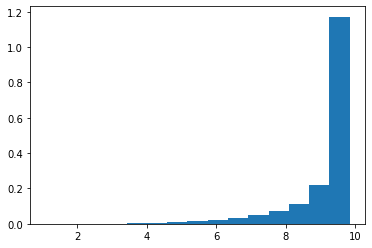

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(vectorizer.idf_, normed=True, bins=15)

In [13]:
voc = []
for word,idx in vectorizer.vocabulary_.items():
    if vectorizer.idf_[idx] >= 9.3:
        voc.append(word)
        

In [14]:
len(voc)

71711

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(voc)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
dictionary = tokenizer.word_index

word2idx = {}
idx2word = {}
for k, v in dictionary.items(): 
    word2idx[k] = v
    idx2word[v] = k

input_data_train = pad_sequences(seq_train, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
input_data_test = pad_sequences(seq_test, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')

In [16]:
import os
import numpy as np
def glove_100d_dictionary(GLOVE_DIR):
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

emd_ind = glove_100d_dictionary("GLOVE_DIR")

In [17]:
len(word2idx)

69410

In [18]:
def embedding_matrix_creater(embedding_dimention):
    embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dimention))
    for word, i in word2idx.items():
        embedding_vector = emd_ind.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

emd_mat = embedding_matrix_creater(100)
emd_mat.shape

(69411, 100)

In [19]:
from sklearn import preprocessing
import tensorflow as tf

label_encoder = preprocessing.LabelEncoder()
lnum_tr = label_encoder.fit_transform(y_train)
lnum_te = label_encoder.transform(y_test)

lab_train = tf.keras.utils.to_categorical(lnum_tr,dtype='float32')
lab_test = tf.keras.utils.to_categorical(lnum_te,dtype='float32')
len(lab_train),len(lab_test)

(13785, 4595)

## Model

In [20]:
VOCAB_SIZE = 69411
EMBEDDING_DIM = 100
MAX_LEN = 1000

In [21]:
def conv_layer(filters,kernel):
    return Conv1D(filters,kernel,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))

In [87]:
encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
embedding_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM,input_length = MAX_LEN, 
                            weights = [emd_mat],trainable = False)(encoder_inputs)
c1 = conv_layer(64,5)(embedding_layer)
c2 = conv_layer(64,5)(embedding_layer)
c3 = conv_layer(64,5)(embedding_layer)
con = Concatenate()([c1,c2,c3])
pool = MaxPooling1D(5)(con)

c4 = conv_layer(16,5)(pool)
c5 = conv_layer(64,5)(pool)
c6 = conv_layer(32,5)(pool)
con2 = Concatenate()([c4,c5,c6])
pool2 = MaxPooling1D(5)(con2)

c7 = conv_layer(16,5)(pool2)
c8 = conv_layer(64,5)(pool2)
c9 = conv_layer(32,5)(pool2)
con3 = Concatenate()([c7,c8,c9])
pool3 = MaxPooling1D(5)(con3)

c7 = conv_layer(32,5)(pool2)
flat = Flatten()(c7)
drop = Dropout(0.3)(flat)
d1 = Dense(128,activation='tanh')(drop)
drop2 = Dropout(0.2)(d1)
out = Dense(20,activation='softmax')(d1)
model = Model(encoder_inputs,out)
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1000, 100)    6941100     input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_171 (Conv1D)             (None, 996, 64)      32064       embedding_18[0][0]               
__________________________________________________________________________________________________
conv1d_172 (Conv1D)             (None, 996, 64)      32064       embedding_18[0][0]               
__________________________________________________________________________________________________
conv1d_173

In [88]:
filepath="weights_email.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [89]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(lnum_tr),
                                                 lnum_tr)


In [90]:
history = model.fit(x=input_data_train, y=lab_train, batch_size=32, epochs=30, verbose=1,callbacks=callbacks_list,
                    validation_data=(input_data_test,lab_test),class_weight=class_weights)

Train on 13785 samples, validate on 4595 samples
Epoch 1/30
13785/13785 [==============================] - 13s 962us/step - loss: 3.4490 - acc: 0.1719 - val_loss: 2.1557 - val_acc: 0.2890

Epoch 00001: val_acc improved from -inf to 0.28901, saving model to weights_email.h5
Epoch 2/30
13785/13785 [==============================] - 10s 707us/step - loss: 2.0753 - acc: 0.3238 - val_loss: 1.8696 - val_acc: 0.3939

Epoch 00002: val_acc improved from 0.28901 to 0.39391, saving model to weights_email.h5
Epoch 3/30
13785/13785 [==============================] - 8s 606us/step - loss: 1.7841 - acc: 0.4398 - val_loss: 1.6461 - val_acc: 0.4940

Epoch 00003: val_acc improved from 0.39391 to 0.49402, saving model to weights_email.h5
Epoch 4/30
13785/13785 [==============================] - 10s 701us/step - loss: 1.6330 - acc: 0.5151 - val_loss: 1.5964 - val_acc: 0.5375

Epoch 00004: val_acc improved from 0.49402 to 0.53754, saving model to weights_email.h5
Epoch 5/30
13785/13785 [===================

In [91]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<pre>
<b>Encoding of the Text </b> --> For a given text data create a Matrix with Embedding layer as shown Below. 
In the example we have considered d = 5, but in this assignment we will get d = dimension of Word vectors we are using.
 i.e if we have maximum of 350 words in a sentence and embedding of 300 dim word vector, 
 we result in 350*300 dimensional matrix for each sentance as output after embedding layer
<img src='https://i.imgur.com/kiVQuk1.png'>
Ref: https://i.imgur.com/kiVQuk1.png

<b>Reference:</b>
<a href='https://stackoverflow.com/a/43399308/4084039'>https://stackoverflow.com/a/43399308/4084039</a>
<a href='https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/'>https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/</a>

<b><a href='https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work'>How EMBEDDING LAYER WORKS </a></b>

</pre>

### Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

<img src='https://i.imgur.com/fv1GvFJ.png'>
ref: 'https://i.imgur.com/fv1GvFJ.png'